In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint

# from sklearn.preprocessing import scale as std_scale, robust_scale
# from scipy.signal import find_peaks, find_peaks_cwt, peak_widths

import numpy as np
from sklearn.preprocessing import scale
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib.animation as ani

import mlgrad.models as models
import mlgrad.regr as regr
import mlgrad.cls as cls
import mlgrad.plots as plots
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.loss as loss
import mlgrad.gd as gd
import mlgrad.smooth as smooth
import mlgrad.array_transform as at
from mlgrad.af import averaging_function
import mlgrad.avragg as avragg

import rampy
import pybaselines
import random

from irsa import io
from irsa.preprocess import despike, utils
import irsa.widgets as widgets

from scipy.special import expit

import copy

# import xarray as xr

import ipywidgets
from IPython.display import display

# %matplotlib widget

In [2]:
# attrs = io.collect_attr_values(f"/home/intellimath/repos/spectras/bacteria")
# pprint(attrs)

In [3]:
def plot_spectra_series(key, i, zval, ix):
    plt.figure(figsize=(12,5))
    entry = dd[key]
    x = entry.x[i]
    ys = entry.y[i]
    plt.title(f"{key} [{len(entry.y)}] [{len(ys)}]")
    for j, y in enumerate(ys):
        plt.plot(y, linewidth=0.5, label=str(j), alpha=0.5)
    # plt.fill_between(x, np.percentile(ys, 20, axis=0), np.percentile(ys, 80, axis=0), interpolate=True, alpha=0.75)
    ys_m = utils.robust_mean2(ys, tau=zval)
    # ys_m_smooth = rampy.whittaker(ys_m, Lambda=1.0e7)
    # max_ys_m = max(ys_m) / 10
    ys_m_smooth = ys_m
    # ys_m_smooth = smooth.whittaker_smooth(ys_m, tau=1.0, solver="fast")
    # ys_m_smooth *= max_ys_m
    # print(f"qvals: {qvals}")
    # plt.plot(x, ys_m, linewidth=1.5, color='k')
    plt.plot(ys_m_smooth, linewidth=1.5, color='k')

    ys_max = np.median(ys_m)
    def arpls(E, exp=np.exp):
        E1 = E[E < 0]
        if len(E1)<1:
            EE = E
        else:
            E1_abs = abs(E1)
            e_m = E1_abs.mean()
            s_m = abs(E1_abs - e_m).mean()
            EE = (E - s_m) / s_m
        # W = 1/(1 + exp(EE))
        W = expit(-3*EE)
        return W
    def rel_error(E,Z):
        abs_E = abs(E)
        return abs_E / max(abs_E)
    def sign2(E):
        # Z = at.array_modified_zscore(E)
        return expit(-E / np.median(abs(E)) / 3)
    def sign(E):
        # Z = at.array_modified_zscore(E)
        e = 1
        return (1 - E / np.sqrt(e*e + E*E))/2

    # yy = ys_m /ys_max
    # bs = smooth.whittaker_smooth(yy, tau=1.)
    bs, dd2 = smooth.whittaker_smooth_weight_func(
        ys_m_smooth, weight_func=sign, weight_func2=rel_error, tau=1000.0, d=2, solver="fast")
    # bs = smooth.whittaker_agg(yy,
    #                           aggfunc=avragg.WMZAverage(
    #                               averaging_function("M", funcs.SoftAbs_Sqrt(0.001)),
    #                               averaging_function("M", funcs.SoftAbs_Sqrt(0.001)),
    #                               c=1.0/0.6745, alpha=3.5),
    #                           aggfunc2=avragg.WMZAverage(
    #                               averaging_function("M", funcs.SoftAbs_Sqrt(0.001)),
    #                               averaging_function("M", funcs.SoftAbs_Sqrt(0.001)),
    #                               c=1.0/0.6745, alpha=3.5),
    #                           tau=10.0)
    # # bs, _ = pybaselines.whittaker.aspls(ys_m_smooth, x_data=x, lam=1.0e4, diff_order=2)
    # bs *= ys_max
    bs = np.ascontiguousarray(bs, "d")
    x = np.ascontiguousarray(x, "d")
    plt.plot(bs, linewidth=2.0, color='m')

    # plt.ylim(0, ys_m.max()+10)
    
    plt.hlines(0, 0, len(ys[0]), colors='k', linestyles='--')
    plt.xlim(*ix)
    # plt.ylim(-10, max(ys[0,42:])+100)
        
    plt.minorticks_on()
    plt.tight_layout()
    # plt.legend([str(i), f"{ds:.2f} / {ds2:.2f} ... {ds4:.4f}", "baseline"])
    plt.show()

def plot_zscore_series(key, i, zval):
    plt.figure(figsize=(12,2))
    # plt.title(f"Modified z-score: {key}: {i}")
    entry = d[key]
    x = entry.x[i]
    ys = entry.y[i]
    zs = utils.modified_zscore2(ys)
    abs_zs = abs(zs)
    for z in abs_zs:
        plt.plot(x, z, linewidth=0.5, alpha=0.5)
    plt.plot(x, utils.robust_mean2(abs_zs, tau=zval), linewidth=2.0, color='k')
    plt.hlines(0, 0, max(x), colors='k', linestyles='--')
    plt.hlines(zval, 0, max(x), colors='k', linewidth=1.0)
    plt.xlim(-10, max(x)+50)
        
    plt.minorticks_on()
    plt.tight_layout()
    plt.legend(["Modified z-score"])
    plt.xticks([])
    plt.show()

In [4]:
path = f"/home/intellimath/repos/spectras/bacteria"
options = {}
dd = {}
widgets.load_spectras(path, dd, options)

SelectMultiple(description='штамм_бактерий', options=('100', '40', '52', '63'), value=())

SelectMultiple(description='резистентность', options=('R', 'S'), value=())

SelectMultiple(description='начальная_концентрация_клеток_в_пробе', options=('6',), value=())

SelectMultiple(description='отсечки_по_молекулярной_массе', options=('less100', 'less100more50', 'less30', 'le…

SelectMultiple(description='номер_эксперимента_в_цикле', options=('5', '6', '7', '8'), value=())

SelectMultiple(description='дата', options=('20240918', '20240923', '20240924', '20240925'), value=())

Button(description='Select', style=ButtonStyle())

Output()

{}

In [5]:
d_keys = list(dd.keys())
sel_i = 0
sel = ipywidgets.Select(options=d_keys,  description="Experiment:", rows=len(dd)+1)
sel.layout.width="50%"

# def sel_on_value_change(change):
#     i_slider.value = 0
#     i_slider.max = len(dd[sel.value].y)-1

# def i_on_value_change(change):
#     plot_spectra_series(sel.value, i_slider.value, f_slider.value)

# def f_on_value_change(change):
#     plot_spectra_series(sel.value, i_slider.value, f_slider.value)

# def tau_on_value_change(change):
#     plot_spectra_series(sel.value, i_slider.value, f_slider.value, tau_slider.value)

# sel.on_trait_change(sel_on_value_change, name="value")
# i_slider.on_trait_change(i_on_value_change, name="value")
# f_slider.on_trait_change(f_on_value_change, name="value")
# tau_slider.on_trait_change(tau_on_value_change, name="value")

# ipywidgets.VBox([sel, i_slider, out])

In [6]:
for i, key in enumerate(dd):
    entry1 = dd[key]
    entry1.crop(50)
    entry1.allign_bottom()    

In [7]:
# for i, key in enumerate(dd):
#     entry1 = dd[key]

    # entry1.remove_overflow_spectras(y_max=2000.0, y_max_count=30)
    # entry1.remove_outlier_spectras(delta=0.10, tau=3.5)
    # entry1.remove_by_zscore_spectras(tau=3.5, max_count=50)
    # print(len(entry1.y))

In [8]:
@ipywidgets.interact(key=sel)
def plot_spectra_for_key(key):
    entry = dd[key]
    entry.plot_spectras()

interactive(children=(Select(description='Experiment:', layout=Layout(width='50%'), options=('SA_100_S_less100…

In [9]:
d2 = {}
for i, key in enumerate(dd):
    entry2 = dd[key]
    d2[key] = entry2.robust_averaging(tau=3.0)


In [10]:
@ipywidgets.interact(key=sel)
def plot_spectra_for_key(key):
    entry = d2[key]
    entry.select_baselines(tau=5000)

interactive(children=(Select(description='Experiment:', layout=Layout(width='50%'), options=('SA_100_S_less100…

In [16]:
for i, key in enumerate(d2):
    entry3 = d2[key]
    # entry3.smooth(method="irsa", tau=1.)
    # entry3.allign_bottom()
    # entry3.normalize_area_under_curve()
    # entry3.remove_by_zscore_spectras(tau=3.5, max_count=40)
    entry3.subtract_baseline("irsa", lam=1000.0)
    # entry3.replace_small_values(0.01)
    # entry3.normalize_area_under_curve()
    # print(entry3.x.shape, entry3.y.shape)
    # entry3.y = entry3.remove_outlier_spectras(tau=3.5)
    # Is = [i for i,ys in enumerate(entry3.y) if np.any(np.isnan(ys))]
    # print(Is)            


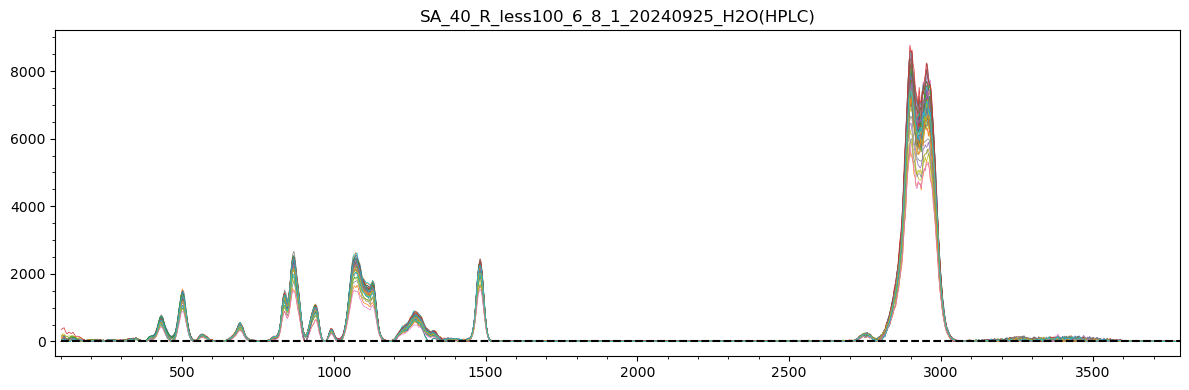

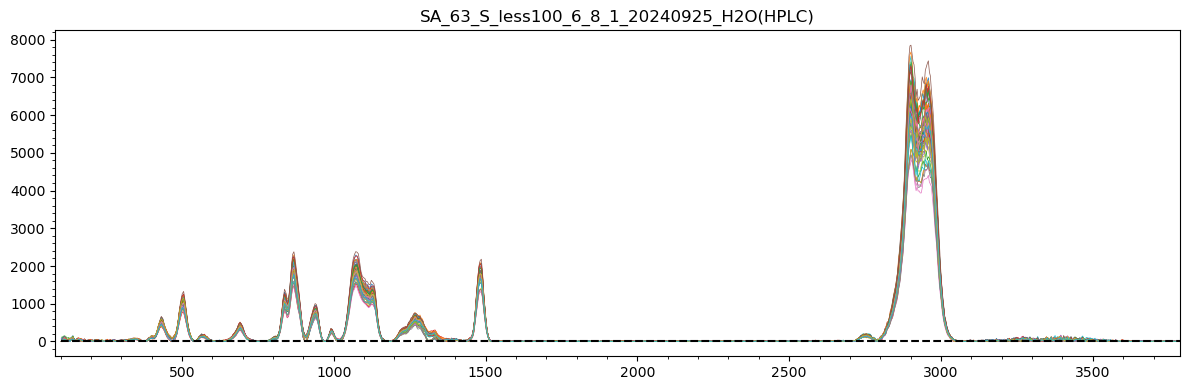

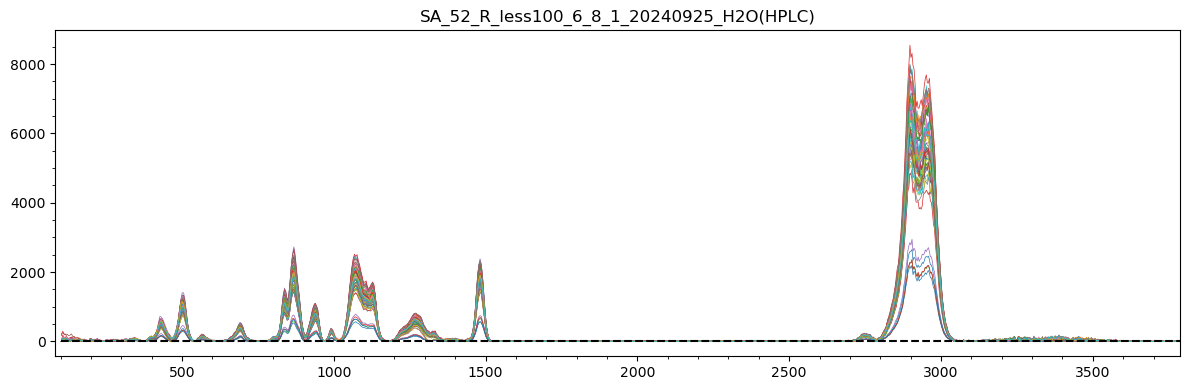

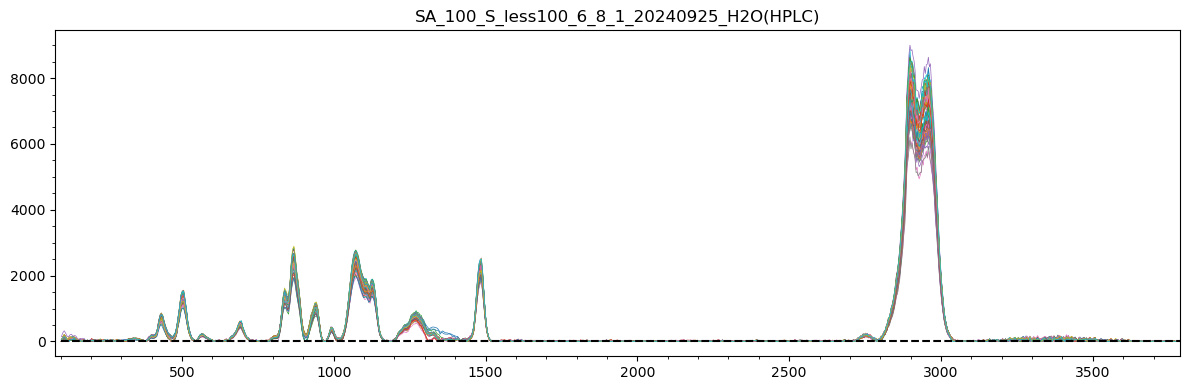

In [17]:
for i, key in enumerate(d2):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    plt.figure(figsize=(12,4))
    plt.title(key)
    for xs, ys in zip(Xs, Ys):
        plt.plot(xs, ys, linewidth=0.5)
    plt.hlines(0, min(xs), max(xs), colors='k', linestyles='--')
    plt.xlim(min(xs)-20, max(xs))
        
    plt.minorticks_on()
    plt.tight_layout()
    # plt.legend()
    plt.show()
    
    # plt.figure(figsize=(12,3))
    # Zs = utils.modified_zscore2(Ys)
    # for xs,zs in zip(Xs,Zs):
    #     plt.plot(xs,abs(zs), linewidth=0.5, marker='s', markersize=1)
    # plt.hlines(3.5, 0, max(xs), colors='k', linestyle='--')
    # plt.minorticks_on()
    # plt.tight_layout()
    # plt.show()
    

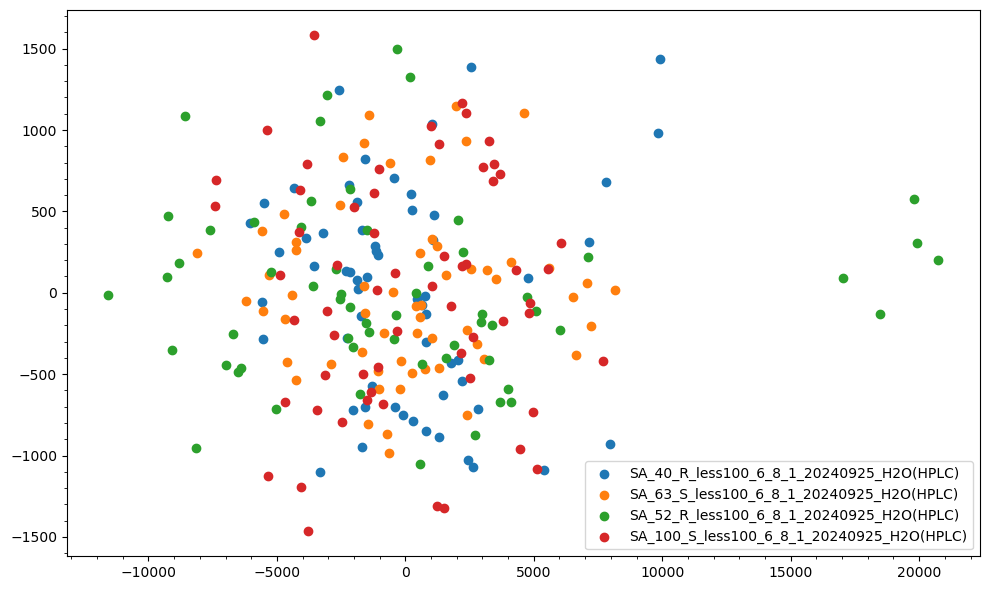

In [18]:
from sklearn.decomposition import PCA
from numpy.linalg import det, inv

plt.figure(figsize=(10,6))
for i, key in enumerate(d2):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    pca = PCA(5)
    pca.fit(Ys)
    Us = pca.transform(Ys)

    S = Us.T @ Us
    S /= np.sqrt(det(S))
    S = inv(S)
    # print(S)


    sc = plt.scatter(Us[:,0], Us[:,1], label=key)
    c = sc.get_facecolor()

    # x_min, x_max = min(Us[:,0]), max(Us[:,0])
    # y_min, y_max = min(Us[:,1]), max(Us[:,1])

    # xr = np.linspace(x_min, x_max, 50)
    # yr = np.linspace(y_min, y_max, 50)
    # xx, yy = np.meshgrid(xr, yr)
    # xy = np.c_[xx.ravel(), yy.ravel()]
    # dd = np.sqrt([0.5*((t @ S) @ t) for t in xy])
    # dd = dd.reshape(xx.shape)
    # plt.contour(dd, levels=[4.0], colors=c)
    

plt.minorticks_on()
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
from mlgrad.pca import location, find_pc_all, find_pc_l1_all

plt.figure(figsize=(10,6))
for i, key in enumerate(d2):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    C = location(Ys)
    As, Ls, Us = find_pc_all(Ys - C, 2)
    plt.plot(Ls, marker='o', label=key)
    # plt.scatter(Us[0], Us[1], label=key)

plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
for i, key in enumerate(d2):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    # if "_R_" in key:
    #     if "95" in key:
    #         color='r'
    #     elif "96" in key:
    #         color='Brown'
    # elif "_S_" in key:
    #     if "92" in key:
    #         color='m'
    #     elif "93" in key:
    #         color='b'
    #     else:
    #         color='b'

    if "_R_" in key:
        color='r'
    elif "_S_" in key:
        color='b'
    else:
        color='m'
        
    # plt.plot(np.mean(Xs, axis=0), np.mean(Ys, axis=0), linewidth=1.0, color=color, label=key)
    plt.plot(np.mean(Ys, axis=0), linewidth=1.0, label=key)
    
# plt.hlines(0, 0, len(Ys[0]), colors='k')
# plt.xlim(-10,1000)
        
plt.minorticks_on()
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
import sympy
from sympy import MatrixSymbol, Identity, latex

In [ ]:
#D = MatrixSymbol('D', 10, 10)
# W = sympy.DiagonalMatrix(MatrixSymbol('w', 8, 8))
w = sympy.symarray("w", (8,), )
W = np.diag(w[1:-1])

In [ ]:
D2 = np.diff(np.eye(8, dtype="i"), 2, axis=0)
print(D2)
print(D2.T @ D2)

In [ ]:
DD2 = np.dot(np.dot(D2.T, W), D2)

In [ ]:
from IPython.display import display, Latex

In [ ]:
s = r"$$\left(\begin{array}{llllllll}"
for i in range(8):
    for j in range(8):
        s += latex(DD2[i,j])
        if j < 7:
            s += r"&"
        else:
            s += r"\\"
s += r"\end{array}\right)$$"
# print(s)
display(Latex(s))

In [ ]:
D1 = np.diff(np.eye(8), 1, axis=0, )
print(D1)
print(D1.T @ D1)

In [ ]:
w = sympy.symarray("w", (7,))
W = np.diag(w)
DD1 = np.dot(np.dot(D1.T, W), D1)

In [ ]:
s = r"$$\left(\begin{array}{llllllll}"
for i in range(8):
    for j in range(8):
        s += latex(DD1[i,j])
        if j < 7:
            s += r"&"
        else:
            s += r"\\"
s += r"\end{array}\right)$$"
# print(s)
display(Latex(s))

In [ ]:
D3 = np.diff(np.eye(9), 3, axis=0, )
print(D3)
print(D3.T @ D3)